# 用底层API实现-摄像头实时预测

同济子豪兄 2023-5-15

## `注意，本代码需要在本地，连接摄像头运行，不能在云GPU平台运行`

## 导入工具包

In [1]:
import cv2
import numpy as np
import time
from tqdm import tqdm

from ultralytics import YOLO
from ultralytics.yolo.data.augment import LetterBox
from ultralytics.yolo.utils import ops

import matplotlib.pyplot as plt
%matplotlib inline

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


## 载入模型

In [2]:
from ultralytics.nn.autobackend import AutoBackend

In [3]:
model = AutoBackend(weights='Triangle_215_yolov8l_pretrain.pt',
                    device=device,
                    dnn=False,                   # 是否将 OpenCV 的 DNN 库用于推理
                    data='Triangle_215.yaml',
                    fp16=False,
                    fuse=True,
                    verbose=False)

_ = model.eval().to(device)

# 切换计算设备
# model.cpu()  # CPU
# model.cuda() # GPU

YOLOv8l-pose summary (fused): 287 layers, 44457390 parameters, 0 gradients, 168.5 GFLOPs


In [4]:
imgsz = [640, 640]

## 可视化配置

In [5]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 2                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':1,         # 字体大小
    'font_thickness':2,    # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-10,        # Y 方向，文字偏移距离，向下为正
}

In [6]:
# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'angle_30', 'color':[255, 0, 0], 'radius':6},      # 30度角点
    1:{'name':'angle_60', 'color':[0, 255, 0], 'radius':6},      # 60度角点
    2:{'name':'angle_90', 'color':[0, 0, 255], 'radius':6},      # 90度角点
}

# 点类别文字
kpt_labelstr = {
    'font_size':1.5,             # 字体大小
    'font_thickness':3,       # 字体粗细
    'offset_x':10,             # X 方向，文字偏移距离，向右为正
    'offset_y':0,            # Y 方向，文字偏移距离，向下为正
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[196, 75, 255], 'thickness':2},        # 30度角点-60度角点
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[180, 187, 28], 'thickness':2},        # 30度角点-90度角点
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[47,255, 173], 'thickness':2},         # 60度角点-90度角点
]

## 逐帧处理函数

In [7]:
def process_frame(img_bgr):
    
    '''
    输入摄像头画面 bgr-array，输出图像 bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    # BGR 转 RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # 缩放图像尺寸
    pre_transform_result = LetterBox(new_shape=imgsz, auto=True)(image=img_rgb)
    # 预处理-归一化
    input_tensor = pre_transform_result / 255
    # 预处理-构造输入张量
    input_tensor = np.expand_dims(input_tensor, axis=0) # 加 Batch 维度
    input_tensor = input_tensor.transpose((0, 3, 1, 2)) # N, C, H, W
    input_tensor = np.ascontiguousarray(input_tensor)   # 将内存不连续存储的数组，转换为内存连续存储的数组，使得内存访问速度更快
    input_tensor = torch.from_numpy(input_tensor).to(device).float() # 转 Pytorch Tensor
    # input_tensor = input_tensor.half() # 是否开启半精度，即 uint8 转 fp16，默认转 fp32 
    
    # 执行推理预测
    preds = model(input_tensor)

    # 后处理-置信度阈值过滤、非极大值抑制NMS过滤
    pred = ops.non_max_suppression(preds, conf_thres=0.25, iou_thres=0.7, nc=1)[0]
    
    # 解析目标检测预测结果
    # 将缩放之后图像的预测结果，投射回原始尺寸
    pred[:, :4] = ops.scale_boxes(pre_transform_result.shape[:2], pred[:, :4], img_bgr.shape).round()
    pred_det = pred[:, :6].cpu().numpy()
    num_bbox = len(pred_det)
    bboxes_cls = pred_det[:, 5] # 类别
    bboxes_conf = pred_det[:, 4] # 置信度
    bboxes_xyxy = pred_det[:, :4].astype('uint32') # 目标检测框 XYXY 坐标

    # 解析关键点检测预测结果
    # 将缩放之后图像的预测结果，投射回原始尺寸
    pred_kpts = pred[:, 6:].view(len(pred), model.kpt_shape[0], model.kpt_shape[1])
    pred_kpts = ops.scale_coords(pre_transform_result.shape[:2], pred_kpts, img_bgr.shape)
    bboxes_keypoints = pred_kpts.cpu().numpy().astype('uint32')

    # OpenCV可视化
    for idx in range(num_bbox): # 遍历每个框

        # 获取该框坐标
        bbox_xyxy = bboxes_xyxy[idx] 

        # 获取框的预测类别（对于关键点检测，只有一个类别）
        bbox_label = model.names[0]

        # 画框
        img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)

        # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])

        bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度

        # 画该框的骨架连接
        for skeleton in skeleton_map:

            # 获取起始点坐标
            srt_kpt_id = skeleton['srt_kpt_id']
            srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
            srt_kpt_y = bbox_keypoints[srt_kpt_id][1]

            # 获取终止点坐标
            dst_kpt_id = skeleton['dst_kpt_id']
            dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
            dst_kpt_y = bbox_keypoints[dst_kpt_id][1]

            # 获取骨架连接颜色
            skeleton_color = skeleton['color']

            # 获取骨架连接线宽
            skeleton_thickness = skeleton['thickness']

            # 画骨架连接
            img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)

        # 画该框的关键点
        for kpt_id in kpt_color_map:

            # 获取该关键点的颜色、半径、XY坐标
            kpt_color = kpt_color_map[kpt_id]['color']
            kpt_radius = kpt_color_map[kpt_id]['radius']
            kpt_x = bbox_keypoints[kpt_id][0]
            kpt_y = bbox_keypoints[kpt_id][1]

            # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
            img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)

            # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
            kpt_label = str(kpt_id) # 写关键点类别 ID（二选一）
            # kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称（二选一）
            img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])
            
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    FPS_string = 'FPS  {:.2f}'.format(FPS) # 写在画面上的字符串
    img_bgr = cv2.putText(img_bgr, FPS_string, (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 255), 2)
    
    return img_bgr

## 摄像头拍摄单帧画面

In [17]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(3) # 运行本代码后等几秒拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [18]:
frame.shape

(720, 1280, 3)

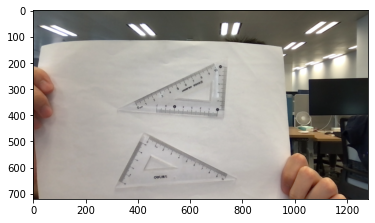

In [19]:
plt.imshow(frame[:,:,::-1])
plt.show()

## 单帧画面关键点检测预测

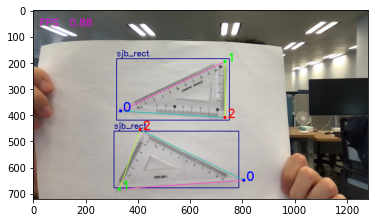

In [20]:
img_bgr = process_frame(frame)

plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 摄像头实时画面逐帧处理（模板）

In [8]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 按`q`键或`Esc`键关闭画面

## 视频逐帧处理（模板）

In [9]:
# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可
# 同济子豪兄 2021-7-10

def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = "out-" + filehead
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except Exception as error:
                    print('报错！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

## 视频预测

In [10]:
generate_video(input_path='triangle_7.mp4')

视频开始处理 triangle_7.mp4
视频总帧数为 220


100%|██████████| 219/219 [00:08<00:00, 25.67it/s]

视频已保存 out-triangle_7.mp4
